# Задача 4. Ансамбли

* **Дедлайн**: 05.04.2024, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- Найти данные размера хотя бы 10000, на которых можно решить задачу классификации или регрессии.
- Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- Самостоятельно реализуйте алгоритмы **Bagging** и **AdaBoost**, которые позволят обучить ансамбли каких-то простых моделей, например деревьев принятия решений.
- Обучите ансамбли для каких-то простых моделей, используя свои две реализации, а также реализации из **sklearn** (**Bagging**, **Random Forest**, **AdaBoost**, **Gradient Tree Boosting**, **Histogram-Based Gradient Boosting**).
-  При обучении использовать **подбор гиперпараметров**, **кросс-валидацию**.
-  Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества, построить матрицы ошибок.
- (**+2 балла**) Также добавить в сравнение модели из библиотек **XGBoost**, **LightGBM** и **CatBoost**.
-  (**+3 балла**) Для подбора гиперпараметров использовать фреймворк **Optuna**.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Датасет
Используемый [Датасет](https://www.kaggle.com/datasets/simaanjali/diabetes-simple-diagnosis), клинические данные ряда пациентов, которые были проанализированы для прогнозирования риска диабета.

Будет решаться задача классификации: определение есть ли у человека диабет.

Нецелевые атрибуты:
  - **Age** - возраст
  - **Gender** - гендер (Male, Female, Others)
  - **BMI** - это мера, которая использует рост и вес человека, чтобы определить, находится ли он в категории нормального веса, избыточного веса или ожирения
  - **High_BP** - показатель того, страдает ли пациент повышенным кровяным давлением
  - **FBS** - отображает уровень глюкозы в крови после ночного голодания
  - **HbA1c_level** - измерение среднего уровня сахара в крови за последние 2-3 месяца
  - **Smoking** - человек курящий или нет

Целевой атрибут:
  - **Diagnosis** - диагноз

In [25]:
df = pd.read_csv('diabet.csv')

# 1.EDA

In [26]:
df.head()

,Unnamed: 0,Age,Gender,BMI,High_BP,FBS,HbA1c_level,Smoking,Diagnosis
0,0,80,Female,25,0,140,6.6,0,0
1,1,54,Female,27,0,80,6.6,0,0
2,2,28,Male,27,0,158,5.7,0,0
3,3,36,Female,23,0,155,5.0,1,0
4,4,76,Male,20,1,155,4.8,1,0


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88380 entries, 0 to 88379
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          88380 non-null  int64  
 1   Gender       88380 non-null  int64  
 2   BMI          88380 non-null  int64  
 3   High_BP      88380 non-null  int64  
 4   FBS          88380 non-null  int64  
 5   HbA1c_level  88380 non-null  float64
 6   Smoking      88380 non-null  int64  
 7   Diagnosis    88380 non-null  int64  
dtypes: float64(1), int64(7)
memory usage: 5.4 MB


Null значений нет

Заменим пол целыми значениями, а также убрем пустую колонку с id

In [34]:
df['Gender'].replace(
    ['Female', 'Male', 'Other'],
    [1, 2, 3],
    inplace=True
)

df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

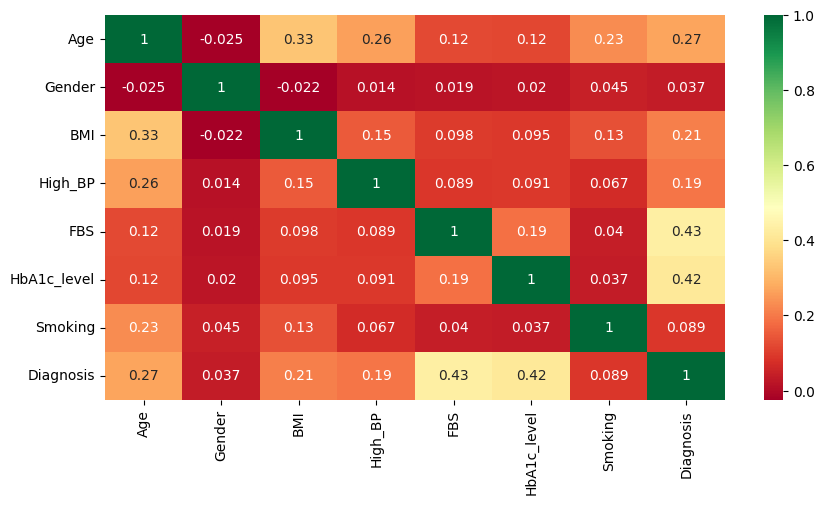

In [35]:
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

Можно заметить некритичную положительную корреляцию между диагнозом и показателями уровня сахара и глюкозы в крови, поскольку они являются одними из ключевых показателей для диагноза.

# Bagging

In [68]:
import numpy as np
from typing import Tuple
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.validation import check_X_y, check_scalar, check_random_state, check_is_fitted, check_array
from sklearn.utils.estimator_checks import check_estimator
from collections import Counter


In [80]:
def get_most_frequent(arr):
    values, counts = np.unique(arr, return_counts=True)
    return values[np.argmax(counts)]

np.random.seed(42)

class MiniBaggingClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, estimator=None, n_estimators=10, random_state=None):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.random_state = random_state


    def fit(self, X, y):
        self.n_estimators = check_scalar(self.n_estimators, "n_estimators", int, min_val=1)
        self.random_state_ = check_random_state(self.random_state)
        X, y = check_X_y(X, y)

        self.estimator_ = self.estimator_ = self.estimator if self.estimator is not None else DecisionTreeClassifier()
        self.classes_ = np.unique(y)

        self.estimators_ = []
        for i in range(self.n_estimators):
            estimator = clone(self.estimator_)
            random_states = {}
            for param_name in estimator.get_params(deep=True):
                if param_name == "random_state" or param_name.endswith("__random_state"):
                    random_states[param_name] = self.random_state_
            estimator.set_params(**random_states)


            indices = self.random_state_.choice(len(y), size=len(y))
            X_mini, y_mini = X[indices], y[indices]

            estimator.fit(X_mini, y_mini)
            self.estimators_.append(estimator)

        self.n_features_in_ = X.shape[1]

        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        predictions = [estimator.predict(X) for estimator in self.estimators_]
        return np.apply_along_axis(get_most_frequent,axis=0, arr=predictions)


check_estimator(MiniBaggingClassifier())

# AdaBoost

In [89]:
class MiniAdaBoostClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, estimator=None, n_estimators=50, random_state=None):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.random_state = random_state

    def fit(self, X, y):
        self.n_estimators = check_scalar(self.n_estimators, "n_estimators", int, min_val=1)
        self.random_state_ = check_random_state(self.random_state)
        X, y = check_X_y(X, y)

        self.estimator_ = self.estimator if self.estimator is not None else DecisionTreeClassifier(max_depth=3)
        self.classes_ = np.unique(y)

        self.estimators_ = []
        self.estimator_weights_ = []
        sample_weight = np.ones(len(y)) / len(y)
        for i in range(self.n_estimators):
            estimator = clone(self.estimator_)
            predicted = estimator.fit(X, y, sample_weight=sample_weight).predict(X)
            errors = predicted != y
            avg_error = np.average(errors, weights=sample_weight)
            if avg_error == 0:
                self.estimators_.append(estimator)
                self.estimator_weights_.append(1.0)
                break
            if avg_error >= 0.5:
                if not self.estimators_:
                    self.estimators_.append(estimator)
                    self.estimator_weights_.append(1.0)
                break

            beta = avg_error / (1 - avg_error)
            sample_weight *=  np.exp(beta * (~errors))
            sample_weight /= np.sum(sample_weight)
            self.estimators_.append(estimator)
            self.estimator_weights_.append(np.log(1 / beta))
        self.estimator_weights_ = np.array(self.estimator_weights_)
        self.n_features_in_ = X.shape[1]
        return self


    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        predictions = np.array([estimator.predict(X) for estimator in self.estimators_]).T
        sorted_prediction_ids = np.argsort(predictions, axis=1)
        sorted_weights_cumsum = np.cumsum(self.estimator_weights_[sorted_prediction_ids], axis=1)
        more_than_median = sorted_weights_cumsum >= (sorted_weights_cumsum[0][-1] / 2)
        median_ids = np.argmax(more_than_median, axis=1)
        median_ids = sorted_prediction_ids[np.arange(X.shape[0]), median_ids]
        return predictions[np.arange(X.shape[0]), median_ids]

check_estimator(MiniAdaBoostClassifier())

# Optuna

In [ ]:
!pip install optuna
!pip install optuna_integration

In [90]:
import pathlib
import warnings

import optuna
from sklearn.model_selection import KFold, cross_validate

optuna.logging.set_verbosity(optuna.logging.WARNING)
optuna.logging.set_verbosity(optuna.logging.INFO)

warnings.filterwarnings("ignore", category=optuna.exceptions.ExperimentalWarning)

RESULTS_PATH = pathlib.Path("results.csv")

def train_and_save(estimator, params):
    study = optuna.create_study(
        sampler=optuna.samplers.BruteForceSampler(),
        direction="maximize",
    )

    optuna_model = optuna.integration.OptunaSearchCV(
        estimator,
        params,
        n_jobs=2,
        n_trials=None,
        random_state=34,
        study=study,
    )

    cv_results = cross_validate(
        optuna_model,
        df.drop(columns=['Diagnosis']),
        df['Diagnosis'],
        cv=KFold(shuffle=True, random_state=42),
        scoring=["accuracy", "precision", "recall", "f1"],
        n_jobs=3,
        return_estimator=True,
    )

    for fold_i, estimator_in_fold in enumerate(cv_results["estimator"], start=1):
        print(f"Best params #{fold_i}:", estimator_in_fold.best_params_)

    cv_results = pd.DataFrame(cv_results)
    cv_results['estimator'] = estimator.__class__.__name__
    cv_results.to_csv(RESULTS_PATH, mode="a", header=not RESULTS_PATH.exists())

In [91]:
%%time

train_and_save(
    MiniBaggingClassifier(random_state=0),
    params={
        "n_estimators": optuna.distributions.CategoricalDistribution([5, 20, 40]),
    },
)

[I 2024-04-07 20:43:13,960] A new study created in memory with name: no-name-731ed3dc-8bb2-44d6-b130-59c87dc832cc


Best params #1: {'n_estimators': 40}
Best params #2: {'n_estimators': 40}
Best params #3: {'n_estimators': 40}
Best params #4: {'n_estimators': 20}
Best params #5: {'n_estimators': 40}
CPU times: user 1.56 s, sys: 454 ms, total: 2.01 s
Wall time: 3min 5s


In [92]:
%%time
from sklearn.ensemble import BaggingClassifier

train_and_save(
    BaggingClassifier(random_state=1, n_jobs=2),
    params={
        "n_estimators": optuna.distributions.CategoricalDistribution([5, 20, 40]),
    }
)

[I 2024-04-07 20:47:03,733] A new study created in memory with name: no-name-2516ce9a-783c-41a3-b405-37be58c7c119


Best params #1: {'n_estimators': 20}
Best params #2: {'n_estimators': 40}
Best params #3: {'n_estimators': 40}
Best params #4: {'n_estimators': 20}
Best params #5: {'n_estimators': 40}
CPU times: user 974 ms, sys: 201 ms, total: 1.17 s
Wall time: 1min 59s


In [93]:
%%time
from sklearn.ensemble import RandomForestClassifier

train_and_save(
    RandomForestClassifier(random_state=2, n_jobs=2),
    params={
        "n_estimators": optuna.distributions.CategoricalDistribution([5, 20, 50]),
        "max_features": optuna.distributions.CategoricalDistribution([2, "sqrt", None]),
        "max_leaf_nodes": optuna.distributions.CategoricalDistribution([10, 100, None]),
    },
)

[I 2024-04-07 20:49:59,782] A new study created in memory with name: no-name-0d733dca-7ada-445c-87ad-36ea577a085b


Best params #1: {'n_estimators': 50, 'max_features': 'sqrt', 'max_leaf_nodes': 100}
Best params #2: {'n_estimators': 50, 'max_features': None, 'max_leaf_nodes': 100}
Best params #3: {'n_estimators': 20, 'max_features': 2, 'max_leaf_nodes': 100}
Best params #4: {'n_estimators': 50, 'max_features': 'sqrt', 'max_leaf_nodes': 100}
Best params #5: {'n_estimators': 50, 'max_features': 2, 'max_leaf_nodes': 100}
CPU times: user 3.53 s, sys: 655 ms, total: 4.19 s
Wall time: 8min 24s


In [94]:
%%time

train_and_save(
    MiniAdaBoostClassifier(random_state=3),
    params={
        "n_estimators": optuna.distributions.CategoricalDistribution([5, 20, 40]),
    },
)

[I 2024-04-07 20:58:24,355] A new study created in memory with name: no-name-bfa992c9-b789-403b-a0bb-f1c507a874f1


Best params #1: {'n_estimators': 5}
Best params #2: {'n_estimators': 20}
Best params #3: {'n_estimators': 5}
Best params #4: {'n_estimators': 5}
Best params #5: {'n_estimators': 5}
CPU times: user 471 ms, sys: 74.6 ms, total: 546 ms
Wall time: 54.9 s


In [95]:
%%time
from sklearn.ensemble import AdaBoostClassifier

train_and_save(
    AdaBoostClassifier(random_state=4),
    params={
        "learning_rate": optuna.distributions.CategoricalDistribution([0.03, 0.1, 0.3]),
        "n_estimators": optuna.distributions.CategoricalDistribution([5, 20, 40]),
    },
)

[I 2024-04-07 20:59:19,237] A new study created in memory with name: no-name-68177ed5-17c3-4c86-b0e9-8709943bfd3a


Best params #1: {'learning_rate': 0.03, 'n_estimators': 20}
Best params #2: {'learning_rate': 0.03, 'n_estimators': 20}
Best params #3: {'learning_rate': 0.1, 'n_estimators': 5}
Best params #4: {'learning_rate': 0.03, 'n_estimators': 20}
Best params #5: {'learning_rate': 0.1, 'n_estimators': 5}
CPU times: user 826 ms, sys: 156 ms, total: 982 ms
Wall time: 1min 45s


In [96]:
%%time
from sklearn.ensemble import GradientBoostingClassifier

train_and_save(
    GradientBoostingClassifier(random_state=5),
    params={
        "learning_rate": optuna.distributions.CategoricalDistribution([0.03, 0.1, 0.3]),
        "n_estimators": optuna.distributions.CategoricalDistribution([5, 20, 100]),
        "max_leaf_nodes": optuna.distributions.CategoricalDistribution([10, 100, None]),
    },
)

[I 2024-04-07 21:01:04,786] A new study created in memory with name: no-name-bb49072f-e650-4026-8b6f-40b73007f535


Best params #1: {'learning_rate': 0.3, 'n_estimators': 20, 'max_leaf_nodes': 10}
Best params #2: {'learning_rate': 0.3, 'n_estimators': 20, 'max_leaf_nodes': 10}
Best params #3: {'learning_rate': 0.3, 'n_estimators': 20, 'max_leaf_nodes': 100}
Best params #4: {'learning_rate': 0.3, 'n_estimators': 100, 'max_leaf_nodes': None}
Best params #5: {'learning_rate': 0.1, 'n_estimators': 100, 'max_leaf_nodes': 10}
CPU times: user 6.05 s, sys: 1.22 s, total: 7.27 s
Wall time: 14min 30s


In [97]:
%%time
from sklearn.ensemble import HistGradientBoostingClassifier

train_and_save(
    HistGradientBoostingClassifier(random_state=6),
    params={
        "learning_rate": optuna.distributions.CategoricalDistribution([0.1, 0.2, 0.3]),
        "max_iter": optuna.distributions.CategoricalDistribution([100, 300, 500]),
        "max_leaf_nodes": optuna.distributions.CategoricalDistribution([3, 15, 40]),
        "early_stopping": optuna.distributions.CategoricalDistribution([False, True]),
    },
)

[I 2024-04-07 21:15:35,067] A new study created in memory with name: no-name-b04e4b26-3b2d-4526-acd8-b564dfc81657


Best params #1: {'learning_rate': 0.1, 'max_iter': 100, 'max_leaf_nodes': 3, 'early_stopping': True}
Best params #2: {'learning_rate': 0.3, 'max_iter': 500, 'max_leaf_nodes': 3, 'early_stopping': True}
Best params #3: {'learning_rate': 0.2, 'max_iter': 500, 'max_leaf_nodes': 3, 'early_stopping': True}
Best params #4: {'learning_rate': 0.3, 'max_iter': 500, 'max_leaf_nodes': 3, 'early_stopping': False}
Best params #5: {'learning_rate': 0.1, 'max_iter': 300, 'max_leaf_nodes': 3, 'early_stopping': False}
CPU times: user 8.47 s, sys: 1.7 s, total: 10.2 s
Wall time: 20min 23s


In [98]:
%%time
from xgboost import XGBClassifier

train_and_save(
    XGBClassifier(random_state=7, n_jobs=2),
    params={
        "tree_method": optuna.distributions.CategoricalDistribution(["exact", "approx", "hist"]),
        "learning_rate": optuna.distributions.CategoricalDistribution([0.03, 0.1, 0.3]),
        "n_estimators": optuna.distributions.CategoricalDistribution([5, 20, 100]),
        "max_leaves": optuna.distributions.CategoricalDistribution([3, 15, 40]),
    },
)

[I 2024-04-07 21:35:58,456] A new study created in memory with name: no-name-5f666cc3-ca47-4567-ad16-18aa4bd06eb1
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params #1: {'tree_method': 'hist', 'learning_rate': 0.3, 'n_estimators': 100, 'max_leaves': 3}
Best params #2: {'tree_method': 'approx', 'learning_rate': 0.3, 'n_estimators': 20, 'max_leaves': 40}
Best params #3: {'tree_method': 'approx', 'learning_rate': 0.3, 'n_estimators': 20, 'max_leaves': 15}
Best params #4: {'tree_method': 'approx', 'learning_rate': 0.1, 'n_estimators': 100, 'max_leaves': 40}
Best params #5: {'tree_method': 'hist', 'learning_rate': 0.3, 'n_estimators': 20, 'max_leaves': 15}
CPU times: user 10.5 s, sys: 2 s, total: 12.5 s
Wall time: 26min 43s


In [99]:
%%time
from lightgbm import LGBMClassifier

train_and_save(
    LGBMClassifier(random_state=8, n_jobs=2),
    params={
        "learning_rate": optuna.distributions.CategoricalDistribution([0.03, 0.1, 0.3]),
        "n_estimators": optuna.distributions.CategoricalDistribution([5, 20, 100]),
        "num_leaves": optuna.distributions.CategoricalDistribution([3, 15, 40]),
    },
)

[I 2024-04-07 22:02:42,631] A new study created in memory with name: no-name-af8518f7-c546-447a-b4dc-5973555cf6df


Best params #1: {'learning_rate': 0.1, 'n_estimators': 20, 'num_leaves': 40}
Best params #2: {'learning_rate': 0.1, 'n_estimators': 20, 'num_leaves': 40}
Best params #3: {'learning_rate': 0.1, 'n_estimators': 20, 'num_leaves': 40}
Best params #4: {'learning_rate': 0.3, 'n_estimators': 100, 'num_leaves': 3}
Best params #5: {'learning_rate': 0.1, 'n_estimators': 20, 'num_leaves': 40}
CPU times: user 1.8 s, sys: 320 ms, total: 2.12 s
Wall time: 2min 57s


In [ ]:
!pip install catboost

In [102]:
%%time
from catboost import CatBoostClassifier

train_and_save(
    CatBoostClassifier(random_state=9, thread_count=2),
    params={
        "n_estimators": optuna.distributions.CategoricalDistribution([100, 300, 500]),
    },
)

[I 2024-04-07 22:08:42,080] A new study created in memory with name: no-name-37903f56-66e4-40b3-a96b-fb5b3f20d862


Best params #1: {'n_estimators': 100}
Best params #2: {'n_estimators': 100}
Best params #3: {'n_estimators': 100}
Best params #4: {'n_estimators': 100}
Best params #5: {'n_estimators': 100}
CPU times: user 2.62 s, sys: 517 ms, total: 3.14 s
Wall time: 5min 36s


In [103]:
results = pd.read_csv(RESULTS_PATH)

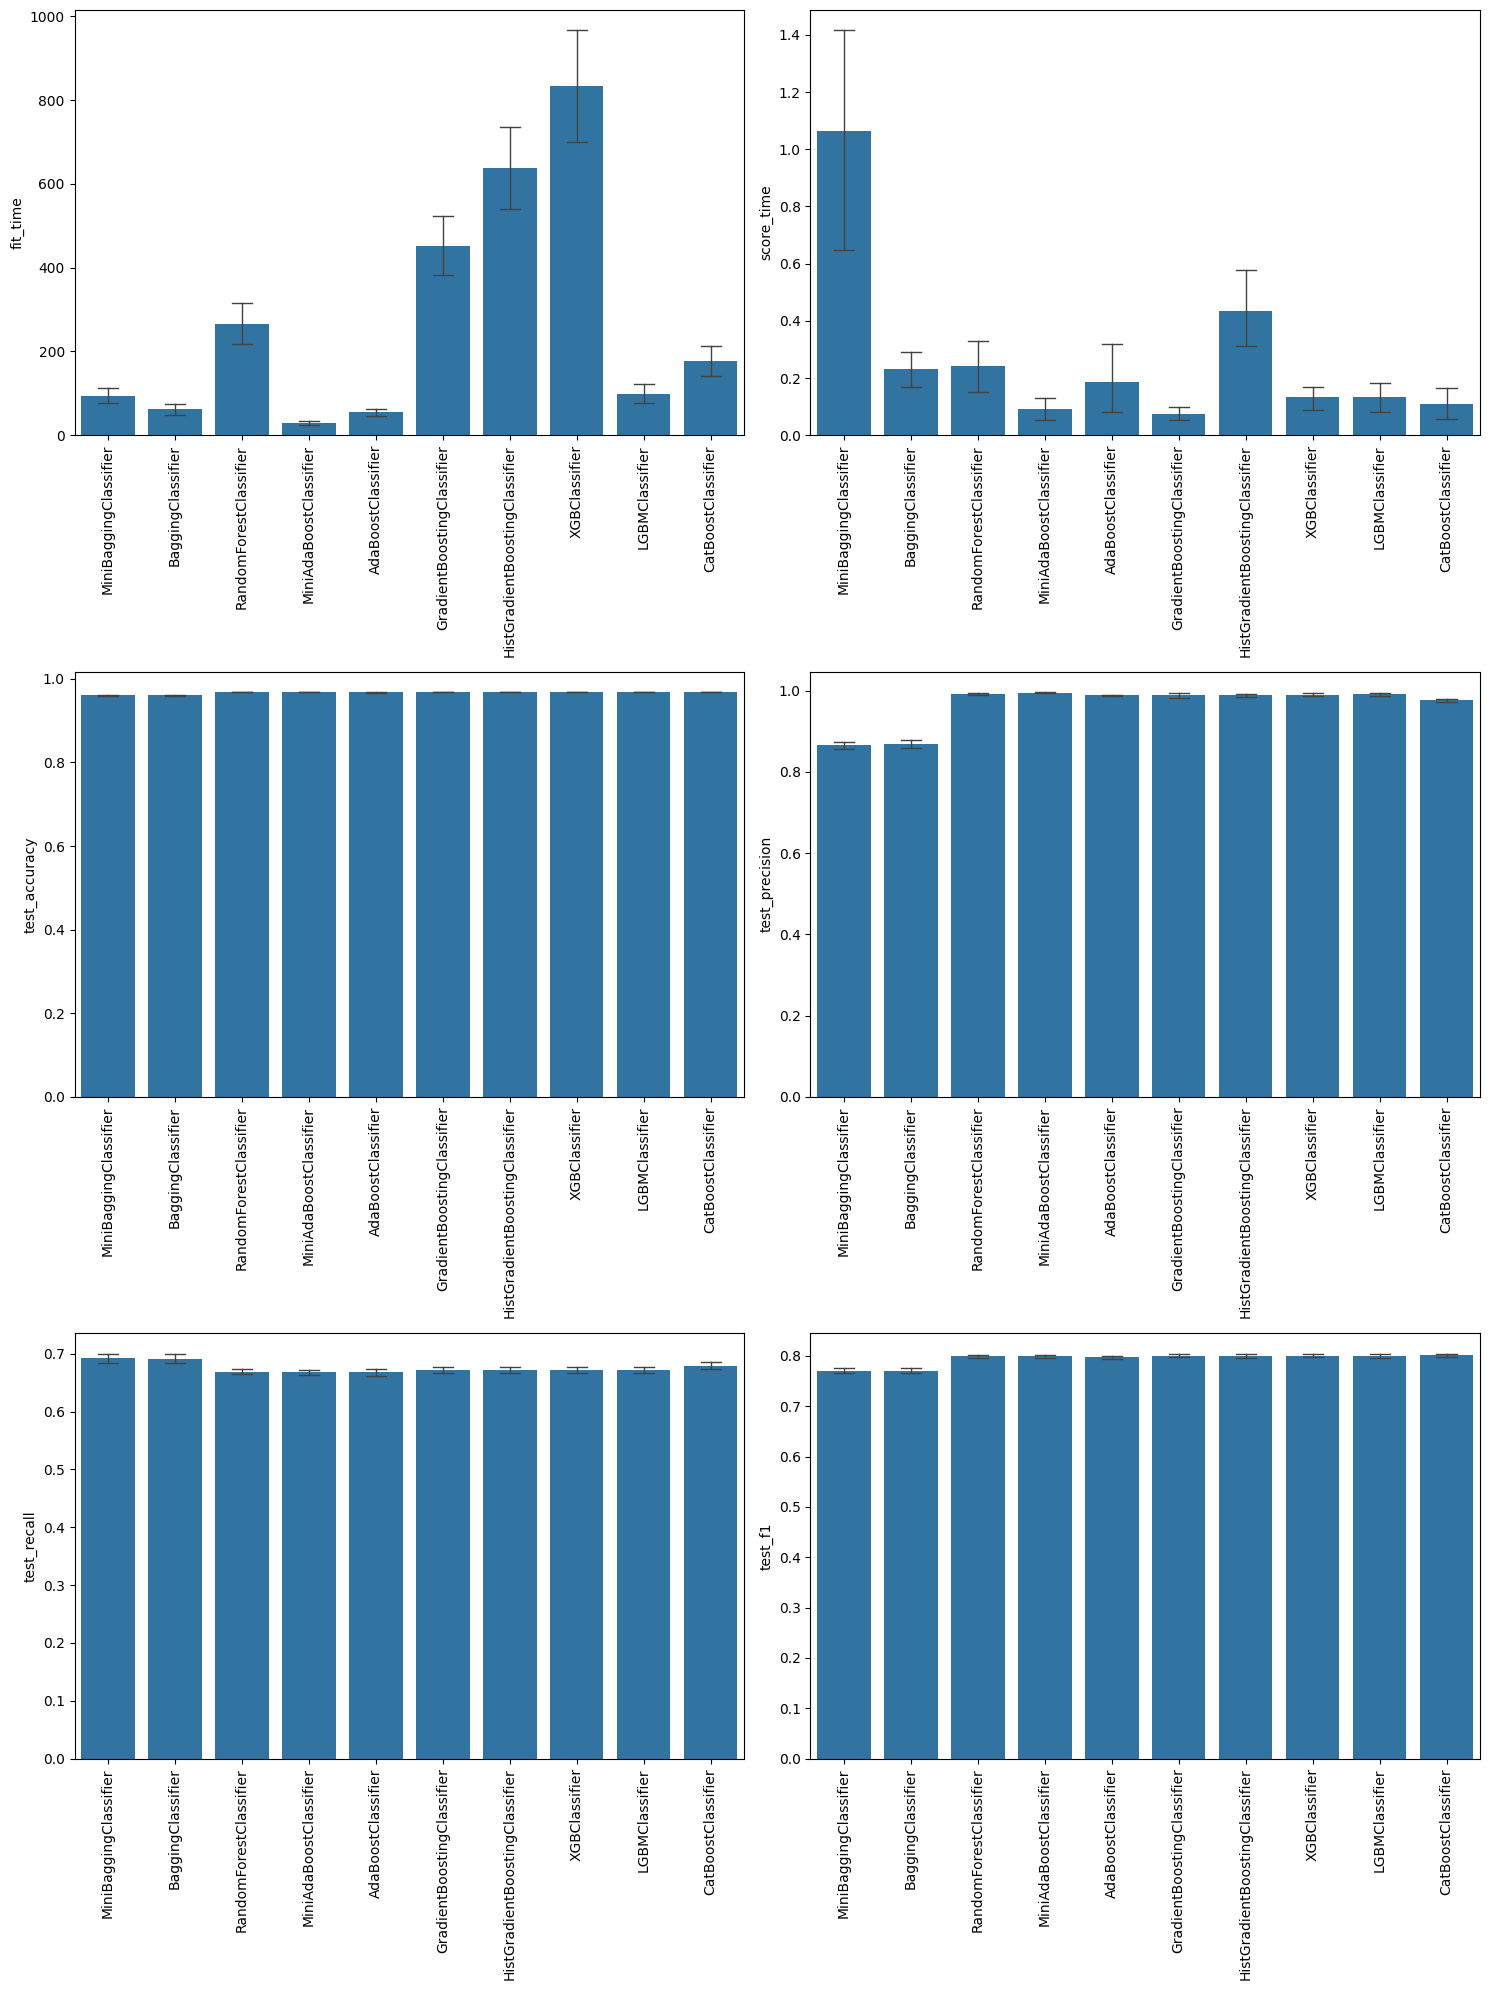

In [105]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 20))

for y, ax in zip(
    ["fit_time",
     "score_time",
     "test_accuracy",
     "test_precision",
     "test_recall",
     "test_f1"
    ], axs.flatten()):
    sns.barplot(results[["estimator", y]], x="estimator", y=y, err_kws={'linewidth': 1}, capsize=0.3, ax=ax)
    ax.tick_params(axis="x", rotation=90)
    ax.set_xlabel(None)

fig.tight_layout()

plt.show()

Можно заметить, что XGBClassifier проигрывает по скорости обучения среди остальных, однако в скорости предсказания проигрывает реализованный MiniBaggingClassifier.

По метрике **accurancy** все модели выдают почти одинаковый результат. По метрикам **precision**, **recall** и **f1** все модели также выдают почти одинаковый результат, помимо моделей с применением Bagging, как реализованный, так и из библиотеки. Они в свою очередь чуть проигрывают по **precision** и **f1**, но также чуть выигрывают в **recall**.